In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import mne_connectivity

In [2]:
%matplotlib inline

## Computing frequency-resolved connectivity between signals

In [3]:
def simulate_signals(
    n_seeds: int,
    n_targets: int,
    freq_band: tuple[int, int],
    n_epochs: int = 10,
    n_times: int = 200,
    sfreq: int = 100,
    snr: float = 0.7,
    connection_delay: int = 10,
    rng_seed: int | None = None,
) -> mne.Epochs:
    """Simulates signals interacting in a given frequency band.

    Parameters
    ----------
    n_seeds : int
        Number of seed channels to simulate.

    n_targets : int
        Number of target channels to simulate.

    freq_band : tuple of int, int
        Frequency band where the connectivity should be simulated, where the
        first entry corresponds to the lower frequency, and the second entry to
        the higher frequency.

    n_epochs : int (default 10)
        Number of epochs in the simulated data.

    n_times : int (default 200)
        Number of timepoints each epoch of the simulated data.

    sfreq : int (default 100)
        Sampling frequency of the simulated data, in Hz.

    snr : float (default 0.7)
        Signal-to-noise ratio of the simulated data.

    connection_delay : int (default 10)
        Number of timepoints for the delay of connectivity between the seeds
        and targets. If > 0, the target data is a delayed form of the seed
        data by this many timepoints.

    rng_seed : int | None (default None)
        Seed to use for the random number generator. If `None`, no seed is
        specified.

    Returns
    -------
    epochs : mne.Epochs
        The simulated data stored in an Epochs object. The channels are
        arranged according to seeds, then targets.
    """
    if rng_seed is not None:
        np.random.seed(rng_seed)

    n_channels = n_seeds + n_targets
    trans_bandwidth = 1  # Hz

    # simulate signal source at desired frequency band
    signal = np.random.randn(1, n_epochs * n_times + connection_delay)
    signal = mne.filter.filter_data(
        data=signal,
        sfreq=sfreq,
        l_freq=freq_band[0],
        h_freq=freq_band[1],
        l_trans_bandwidth=trans_bandwidth,
        h_trans_bandwidth=trans_bandwidth,
        fir_design="firwin2",
        verbose=False,
    )

    # simulate noise for each channel
    noise = np.random.randn(n_channels, n_epochs * n_times + connection_delay)

    # create data by projecting signal into noise
    data = (signal * snr) + (noise * (1 - snr))

    # shift target data by desired delay
    if connection_delay > 0:
        # shift target data
        data[n_seeds:, connection_delay:] = data[
            n_seeds:, : n_epochs * n_times
        ]
        # remove extra time
        data = data[:, : n_epochs * n_times]

    # reshape data into epochs
    data = data.reshape(n_channels, n_epochs, n_times)
    data = data.transpose((1, 0, 2))  # (epochs x channels x times)

    # store data in an MNE Epochs object
    ch_names = [
        f"{ch_i}_{freq_band[0]}_{freq_band[1]}" for ch_i in range(n_channels)
    ]
    info = mne.create_info(
        ch_names=ch_names, sfreq=sfreq, ch_types="eeg", verbose=False
    )
    epochs = mne.EpochsArray(data=data, info=info, verbose=False)

    return epochs

In [4]:
def plot_connectivity(results: np.ndarray, freqs: list):
    """Plots connectivity results for a single connection.
    
    Parameters
    ----------
    results : numpy.ndarray, shape of (frequencies)
        Results for a single connection.
    
    freqs : list
        Frequencies in `results`.
    """
    if results.shape != (len(freqs), ):
        raise ValueError(
            "`results` must be a 1D array with the same length as `freqs`."
        )
    fig, ax = plt.subplots(1, 1)
    ax.plot(freqs, results, linewidth=3)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Connectivity (A.U.)")
    plt.show()

### Part 1 - Simulating connectivity

The function above, `simulate_signals`, simulates some data with interactions at a given frequency range.

We will use this as a starting point to explore connectivity computations in MNE.

We start by simulating two interacting channels in the frequency range 5-10 Hz.

In [5]:
epochs_5_10 = simulate_signals(n_seeds=1, n_targets=1, freq_band=(5, 10))

**Exercises - simulating connectivity**

1a) Verify that activity is present in the 5-10 Hz frequency range of these channels.

*Hint:* Both signals should contain activity in this frequency range.

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\201905642.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_5_10.compute_psd().plot();
c:\Users\tsbin\anaconda3\envs\mne_course\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


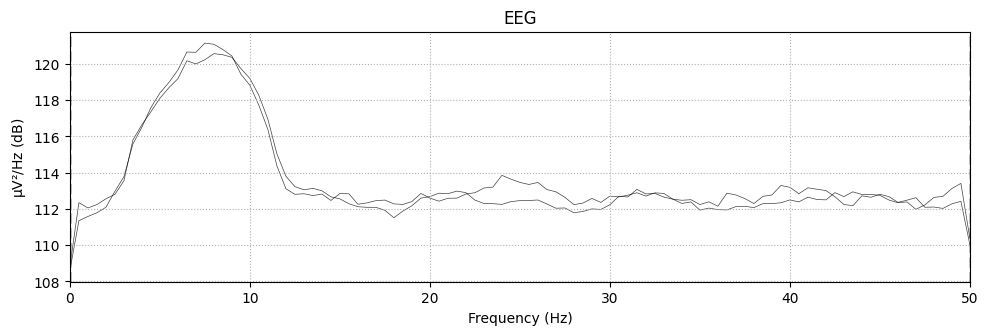

In [6]:
## CODE GOES HERE
epochs_5_10.compute_psd().plot();

1b) Now do the same for an interaction in the 15-20 Hz range.

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\1531044973.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_15_20.compute_psd().plot();
c:\Users\tsbin\anaconda3\envs\mne_course\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


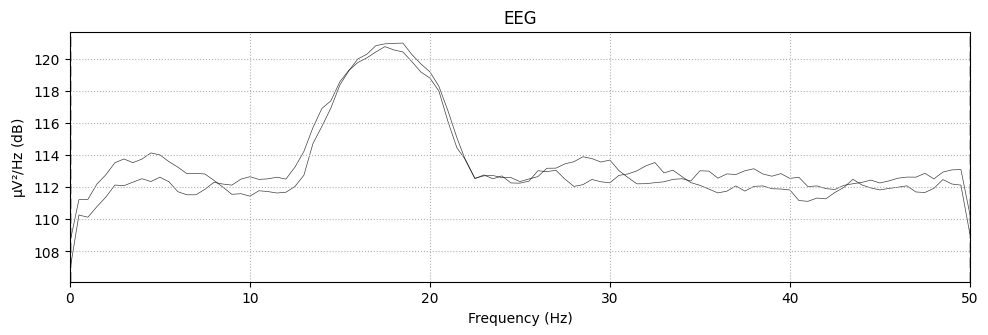

In [7]:
## CODE GOES HERE
epochs_15_20 = simulate_signals(n_seeds=1, n_targets=1, freq_band=(15, 20))
epochs_15_20.compute_psd().plot();

1c) And again for the 25-30 Hz range.

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\969530374.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_25_30.compute_psd().plot();
c:\Users\tsbin\anaconda3\envs\mne_course\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


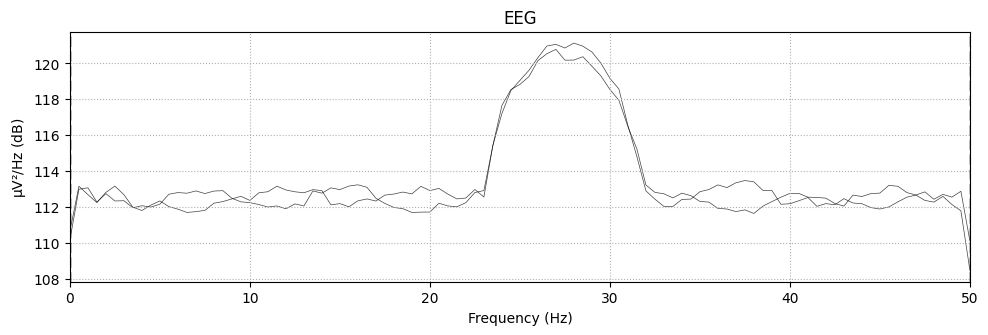

In [8]:
## CODE GOES HERE
epochs_25_30 = simulate_signals(n_seeds=1, n_targets=1, freq_band=(25, 30))
epochs_25_30.compute_psd().plot();

Now, we combine all three connectivity simulations into a single `Epochs` object.

In [9]:
epochs = epochs_5_10.copy().add_channels([epochs_15_20, epochs_25_30])

### Part 2 - `mne_connectivity.spectral_connectivity_epochs()`

We will use the function [`mne_connectivity.spectral_connectivity_epochs()`](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html#mne_connectivity.spectral_connectivity_epochs) to compute connectivity between the simulated signals.

By default, connectivity is computed between all channels using the coherence method.

In [10]:
connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 15 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\2685388718.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs)


As you can see from the logging output, without specifying which channels to compute connectivity between, 15 connections are computed. This corresponds to the number of unique combinations of our channels (`channels * (channels - 1) / 2`).

However, such all-to-all connectivity results can also be represented as a dense array of shape `(channels, channels, frequencies)`, where the lower triangular elements are filled with the connectivity results, and all other elements are zeros. This makes indexing the results easier, and is what MNE returns when no channels are specified.<br>
Hence, 36 connections are actually returned (6^2, with only the lower triangular elements filled).

The results are returned as a [`SpectralConnectivity`](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.SpectralConnectivity.html#mne_connectivity.SpectralConnectivity) object, and the array of results can be accessed with the `get_data()` method.<br>
By default, `get_data()` returns the results as a raveled array with shape `(connections, frequencies)`.<br>
We can also specify `get_data()` to return the results in the dense array form with shape `(channels, channels, frequencies)`. This will be easier index for the following exercises.

The frequencies corresponding to the connectivity results can be accessed under the `freqs` attribute.

In [11]:
print(f"Default results shape: {connectivity.get_data().shape}")
print(f"Dense results shape: {connectivity.get_data("dense").shape}")

Default results shape: (36, 96)
Dense results shape: (6, 6, 96)


Here, we extract the connectivity information for the 5-10 Hz interaction between channel 0 and channel 1. Plotting the results shows that these are the connectivity results for the 5-10 Hz interaction.

*Hint:* Because the connectivity results are stored in the lower-triangular elements, the positions of the seed and target channels must be switched.

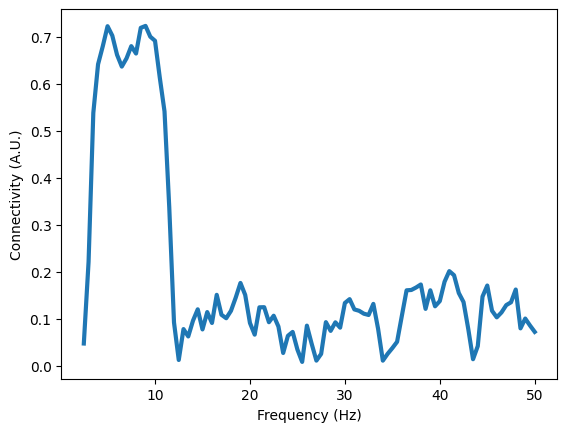

In [12]:
conn_5_10 = connectivity.get_data("dense")[1, 0]  # (target index, seed index)
plot_connectivity(conn_5_10, connectivity.freqs)

**Exercises - extracting connectivity results**

2a) Now do the same for the 15-20 Hz interaction.

*Hint:* This involved channels 2 and 3.

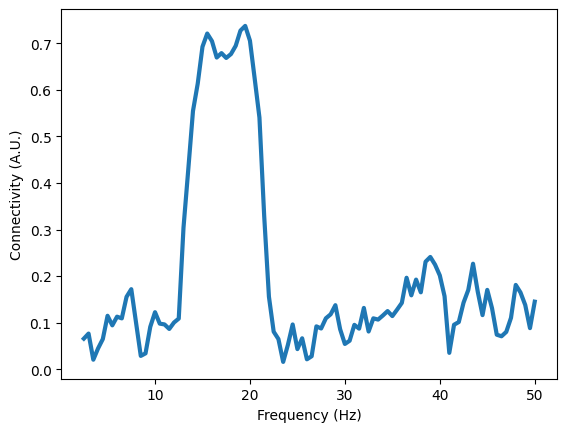

In [13]:
## CODE GOES HERE
conn_15_20 = connectivity.get_data("dense")[3, 2]
plot_connectivity(conn_15_20, connectivity.freqs)

2b) And finally, do the same for the 25-30 Hz interaction.

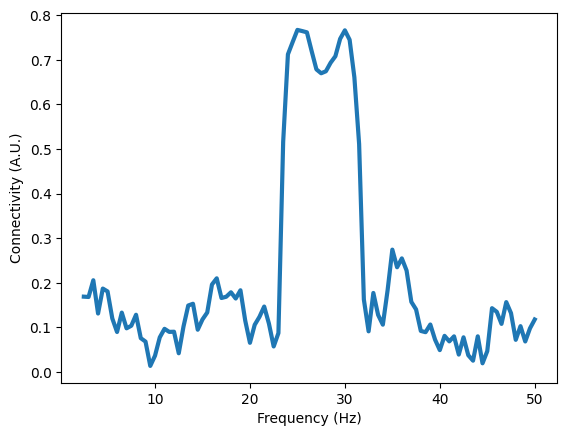

In [14]:
## CODE GOES HERE
conn_25_30 = connectivity.get_data("dense")[5, 4]
plot_connectivity(conn_25_30, connectivity.freqs)

### Part 3 - The `indices` parameter

Of course, it is inefficient to compute all combinations of connections if we are only interested in a few of them. This is where the `indices` parameter is needed.

Connections indices in MNE takes the form of a tuple of two array-likes, specifying the seed and target channels, respectively, e.g. `indices = (seeds, targets)`, and connectivity will be computed for only these particular combinations.

Here, we specify that connectivity should only be computed between channels 0 and 1 (the 5-10 Hz interaction) with `indices = ([0], [1])`.

In [15]:
connectivity_5_10 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([0], [1]))

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
[Connectivity computation done]


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\3967892653.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  connectivity_5_10 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([0], [1]))


From the logging output, we can see that only one connection is computed.

Accordingly, when we call `get_data()`, there is only one connection to index, and plotting the results show us we have indeed selected the 5-10 Hz interaction.

(1, 96)


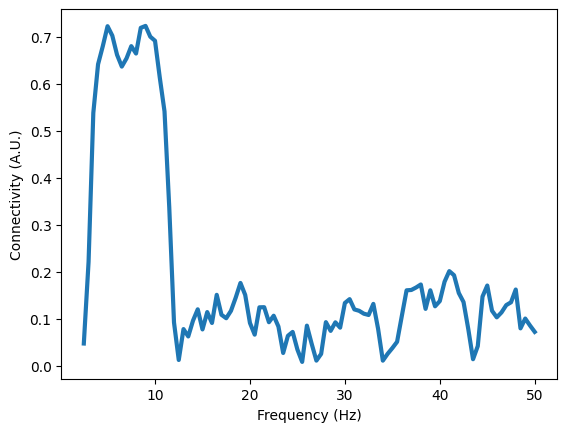

In [16]:
print(connectivity_5_10.get_data().shape)
plot_connectivity(connectivity_5_10.get_data()[0], connectivity_5_10.freqs)

**Exercises - specifying the indices**

3a) Now do the same for the 15-20 Hz interaction.

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
[Connectivity computation done]
(1, 96)


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\535023353.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  connectivity_15_20 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([2], [3]))


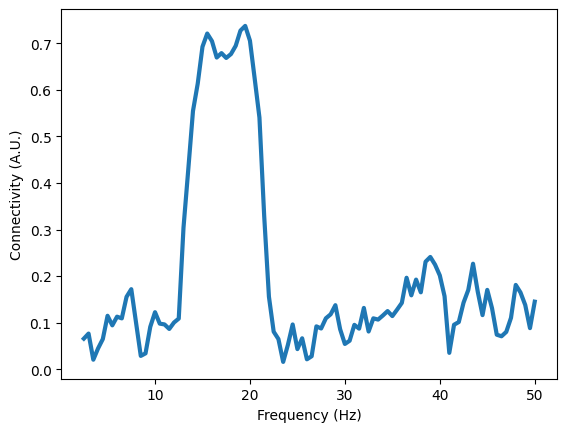

In [17]:
## CODE GOES HERE
connectivity_15_20 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([2], [3]))
print(connectivity_15_20.get_data().shape)
plot_connectivity(connectivity_15_20.get_data()[0], connectivity_15_20.freqs)

3b) And again for the 25-30 Hz interaction.

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
[Connectivity computation done]


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\2567845629.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  connectivity_25_30 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([4], [5]))


(1, 96)


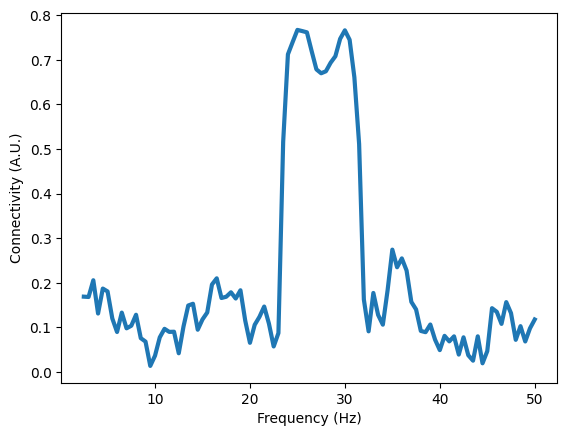

In [18]:
## CODE GOES HERE
connectivity_25_30 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([4], [5]))
print(connectivity_25_30.get_data().shape)
plot_connectivity(connectivity_25_30.get_data()[0], connectivity_25_30.freqs)

Alternatively, we can specify multiple connections at once by providing multiple seeds and targets.

3c) Try this now for two sets of the interacting channels, and verify that two connections were computed.

Connectivity computation...
    computing connectivity for 2 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
[Connectivity computation done]
(2, 96)


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\529532463.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([0, 2], [1, 3]))


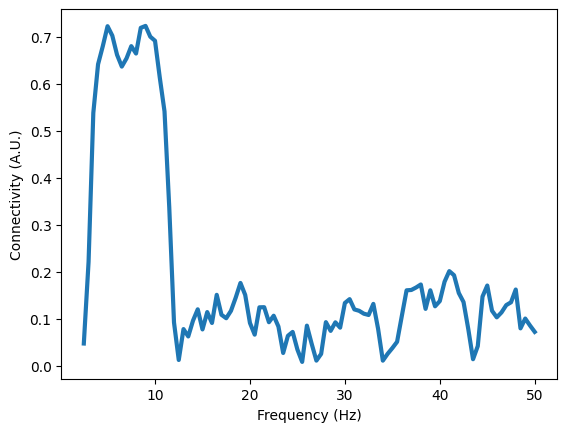

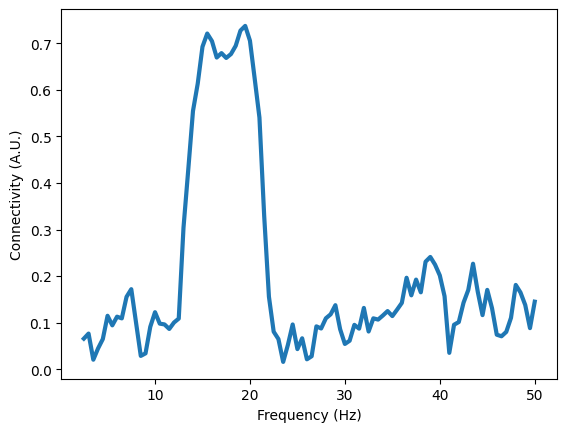

In [19]:
## CODE GOES HERE
connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([0, 2], [1, 3]))
print(connectivity.get_data().shape)
for con_i in range(connectivity.get_data().shape[0]):
    plot_connectivity(connectivity.get_data()[con_i], connectivity.freqs)

3d) Now try this for all three sets of interactions, and verify that all three connections are present.

Connectivity computation...
    computing connectivity for 3 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
[Connectivity computation done]
(3, 96)


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\3205506824.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([0, 2, 4], [1, 3, 5]))


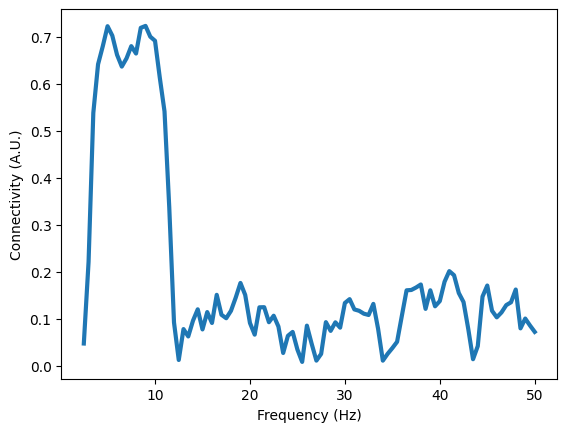

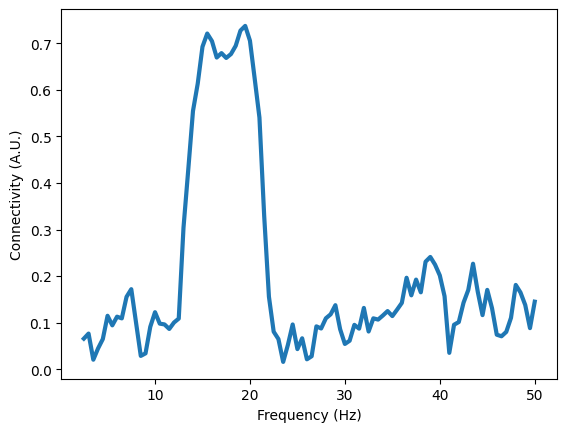

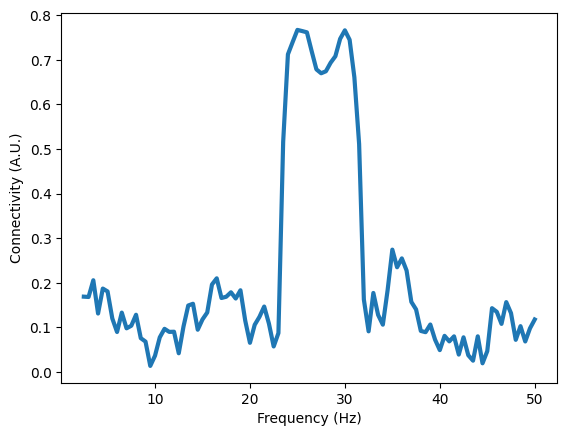

In [20]:
## CODE GOES HERE
connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([0, 2, 4], [1, 3, 5]))
print(connectivity.get_data().shape)
for con_i in range(connectivity.get_data().shape[0]):
    plot_connectivity(connectivity.get_data()[con_i], connectivity.freqs)

By specifying the `indices` parameter, we can be much more efficient by only computing the connections we are interested in.

### Part 4 - The `method` parameter

Until now, we have been using the default connectivity method - `"coh"` (coherence). However, several such methods are available depending on the sort of connectivity you are interested in.

`method` can be specified as a string for a single method, or a list of strings for multiple methods.

To start off, we can explicitly pass coherence ("coh") as the desired method, and using the `method` attribute of the `SpectralConnectivity` object, we can verify that coherence has been computed.

In [21]:
coh = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="coh")
print(f"The computed method is: {coh.method}")

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 15 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
The computed method is: coh


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\3523409065.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  coh = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="coh")


**Exercises - specifying the connectivity method**

4a) Now specify a different connectivity method.

*Hint:* A list of all methods is available in the [documentation](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html#mne_connectivity.spectral_connectivity_epochs).

In [22]:
## CODE GOES HERE
imcoh = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="imcoh")
print(f"The computed method is: {imcoh.method}")

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 15 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
The computed method is: imcoh


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\2119209318.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  imcoh = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="imcoh")


4b) Now specify another method.

In [23]:
## CODE GOES HERE
cohy = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="cohy")
print(f"The computed method is: {cohy.method}")

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 15 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherency
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
The computed method is: cohy


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\3749714589.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  cohy = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="cohy")


4c) Now specify all three methods at once. What do you notice about the output of the function?

In [24]:
## CODE GOES HERE
con_methods = mne_connectivity.spectral_connectivity_epochs(data=epochs, method=["coh", "imcoh", "cohy"])

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 15 connections
    using t=0.000s..1.990s for estimation (200 points)
    frequencies: 2.5Hz..50.0Hz (96 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, Imaginary Coherence, Coherency
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]


C:\Users\tsbin\AppData\Local\Temp\ipykernel_14792\233163322.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 – 1.99 s, baseline off, ~103 kB, data loaded,
 '1': 10>, so metadata was not modified.
  con_methods = mne_connectivity.spectral_connectivity_epochs(data=epochs, method=["coh", "imcoh", "cohy"])


4d) Try to access the results for each of the connectivity methods. What do you notice about the order in which the results for each method is returned?

In [25]:
## CODE GOES HERE
coh = con_methods[0]
print(coh.method)

coh


In [26]:
## CODE GOES HERE
imcoh = con_methods[1]
print(imcoh.method)

imcoh


In [27]:
## CODE GOES HERE
cohy = con_methods[2]
print(cohy.method)

cohy
